In [ ]:
import torch
import torch.nn as nn

# Land Cover Classification at 1-meter Spatial Resolution Using U-Net

Land cover classification is an important task in remote sensing due to its wide applicability in many areas of research - including monitoring natural resources, climate change and urban development. At medium spatial resolutions (such as those produced using data from LandSat satellites), land cover is typically classified on a pixel-by-pixel basis using the spectral response of each pixel and a machine learning algorithm such as random forest or k-NN. However, as spatial resolution increases - the intra-class variance of the data also increases, making pixel-based approaches ineffective for land cover classification. However, as the spatial resolution of remote sensing data is increased, spatial features in the source data emerge that are not visible at lower resolutions. Thus, effective methods for land cover classification at higher resolutions typically necessitate encoding of spatial features. Deep learning-based computer vision architectures are one method that enable researchers to utilize such spatial features in analyzing geospatial data. In this project, we will show how to use U-Net - a deep learning semantic segmentation architecture - to build and train a model for land cover classification using USDA National Agricultural Imagery Program (NAIP) data at 1-meter spatial resolution.

## USDA National Agricultural Imagery Program (NAIP)

USDA NAIP is a program that utilizes spectral sensors mounted on aerial platforms to produce high-resolution optical data over large regions. NAIP 

## Loading data

In order to load data from rasters into python, we need to use the `rasterio` module. Below is an example of how to open and visualize a file using rasterio.

### Finding files

Before we can load files, we need to know where they are at. In this case, there is some NAIP data that has aleady been sampled stored in `./data` with the following directory structure:

```
| data/
|| NAIP_PATCH_ID/ 
||| input/
|||| 00000.tif (sample from corresponding patch)
|||| 00001.tif
|||| 00002.tif
|||| ...
||| target/
|||| 00000.tif (sampl from corresponding patch's ground truth data)
|||| 00001.tif
|||| 00002.tif
|||| ...
```

Knowing this, we can write a function that aggregates the NAIP data and their corresponding ground truth labels into a list of 2-tuples.

In [6]:
import os
def get_list_of_files(data_path: str='./data') -> list[tuple[str, str]]:
    '''Returns a list of tuples of the form (path_to_input_sample, path_to_label)'''
    
    # get list of patch ids. list comprehension pretty much says "look at the 
    # items in the data_path directory and if they are directories, add them to 
    # the list"
    file_paths = []
    patch_ids = [sub_dir for sub_dir in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, sub_dir))]
    
    for patch in patch_ids:
        try:
            # get all subsamples of each patch
            subsamples = os.listdir(os.path.join(data_path, patch, 'input'))
            # add subsamples to file_path list
            file_paths.extend(
                (
                    os.path.join(data_path, patch, 'input', subsample),
                    os.path.join(data_path, patch, 'target', subsample)
                ) for subsample in subsamples
            )
        
    
    # check to make sure files exist
    for file_path in file_paths:
        if not os.path.isfile(file_path[0]):
            raise FileNotFoundError(f'Input file {file_path[0]} not found')
        if not os.path.isfile(file_path[1]):
            raise FileNotFoundError(f'Label file {file_path[1]} not found')
    
    return file_paths

file_paths = get_list_of_files('data')
print(f'Found {len(file_paths)} files') # always a good idea to print out the number of files found
print(file_paths[0]) # take a look at the first file path input/target 2-tuple

Found 2464 files
('data\\m_3607626_ne_18_1\\input\\00000.tif', 'data\\m_3607626_ne_18_1\\target\\00000.tif')


### Loading rasters with `rasterio`

`rasterio` is a handy Python package for reading and writing geospatial raster data. Using `rasterio`, we can load in both the source data and the target land cover labels for use in training the model. In this case, the provided NAIP data from EarthExplorer has 4-bands:

Band 1 - Red
Band 2 - Blue
Band 3 - Green
Band 4 - Near-Infrared.

*Remember:* Python is 0-indexed, meaning band 1 is accessed using `my_raster[0]` instead of `my_raster[1]`. In addition to reading in raster data as `numpy` arrays, we can also load and store the geospatial metadata associated with the raster, which includes the transformation matrix and the CRS. This is useful for saving modifications to the 

Loading NAIP raster from data\m_3607626_ne_18_1\input\00010.tif...
raster metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 224, 'height': 224, 'count': 4, 'crs': CRS.from_epsg(26918), 'transform': Affine(1.0, 0.0, 339671.0,
       0.0, -1.0, 4051592.0)}
raster shape: (4, 224, 224)


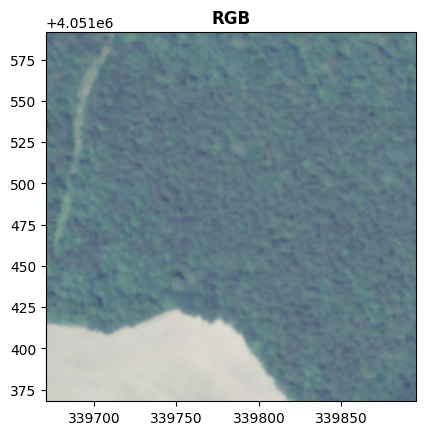

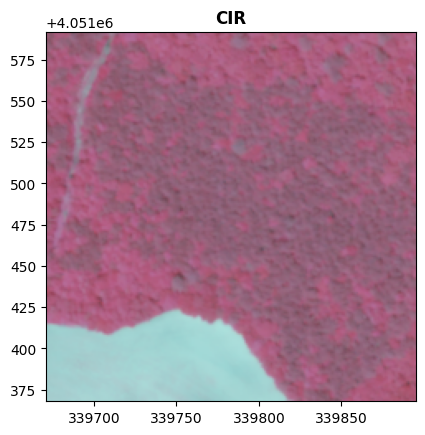

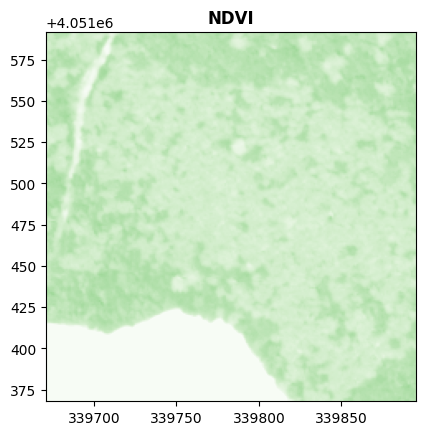

<Axes: title={'center': 'NDVI'}>

In [30]:
import rasterio
import numpy as np
from rasterio.plot import show

# grab a file path
src_file = file_paths[10][0]
print(f'Loading NAIP raster from {src_file}...')
with rasterio.open(src_file) as src:
    meta = src.meta # grab geo metadata
    data = src.read() # grab raster data (as numpy array)
    # NOTE: rasterio follows GDAL convention of 1-indexed bands when using .read()
    # assert data[0] == src.read(1) # this is true
    
# NOTE: NAIP imagery is stored as uint8, which means values range from 0-255
# we can change the data type to make data manipulation easier. For example:
data = data.astype(np.int16) # convert to int16 for more range (useful for indices like NDVI)

    
print('raster metadata:', meta)
print('raster shape:', data.shape) # NOTE: rasterio reads in (bands, rows, cols) format
data_rgb = data[:3]
data_cir = data[[3, 0, 1], :, :] # grab only the NIR R G bands
data_ndvi = np.divide(np.subtract(data[3], data[0]), np.add(data[3], data[0])) # calculate NDVI using NumPy array operations

# we can use rasterio.plot.show to plot the raster data with the correct geo transform
show(data_rgb, transform=meta['transform'], vmin=0, vmax=255, title='RGB')
show(data_cir, transform=meta['transform'], vmin=0, vmax=255, title='CIR')
show(data_ndvi, transform=meta['transform'], vmin=0, vmax=1, cmap='Greens', title='NDVI')

Before we continue, let's write a few helper fumctions for working with raster data. First, we'll create a function that gives us raster/array statistics (size, shape, min, max, etc.), then we'll write a function that uses `matplotlib` to help plot multiple rasters at once. We'll also create a function for plotting land cover maps with a legend. These are the land cover classes in the Chesapeake Bay Land Cover dataset:

```
1 - water
2 - tree canopy/forest
3 - low vegetation/field
4 - barren
5 - impervious other
6 - impervious road
```

In [ ]:
def print_array_statistics(data: np.ndarray) -> None:
    print(f'mean: {np.mean(data)}, std: {np.std(data)}, min: {np.min(data)}, max: {np.max(data)}')

# create colormap for landcover classes
from matplotlib.colors import ListedColormap
chesapeake_bay_colormap = ListedColormap(['aqua', 'darkgreen', 'lawngreen', 'lightyellow', 'dimgray', 'lightgray'])

# create a legend for the landcover classes
from matplotlib.patches import Patch
land_cover_map_legend_elements = [
    Patch(edgecolor='black', facecolor='aqua', label='Water'),
    Patch(edgecolor='black', facecolor='darkgreen', label='Tree Canopy/Forest'),
    Patch(edgecolor='black', facecolor='lawngreen', label='Low Vegetation/Field'),
    Patch(edgecolor='black', facecolor='lightyellow', label='Barren'),
    Patch(edgecolor='black', facecolor='dimgray', label='Impervious Other'),
    Patch(edgecolor='black', facecolor='lightgray', label='Impervious Road'),
]

import matplotlib.pyplot as plt
def plot_rasters(data, transform, title):
    
    if type(data) != list:
        data = [data]
        
    n_plots = len(data)
    fig, axes = plt.subplots(1, len(data), figsize=(5*n_plots, 5))
    axes.ravel()
    for i, ax in enumerate(axes):
        if data[i].dtype == float:
            ax.imshow(data[i], transform=transform, vmin=0, vmax=1)
        else:
            ax.imshow(data[i], transform=transform, vmin=0, vmax=255)
        ax.set_title(title[i])



### Housecleaning - Data Augmentation using Image Transformations

Before we write the code used for loading data to 

### Creating a Dataset class

In order to load data to train a neural network model in PyTorch, we need to create a custom class that tells PyTorch *how* to load each sample into memory, and what transformations need to be performed on each sample. If you're unfamiliar with this practice, you may not immediately see the value in it compared to simply using a list of samples or `numpy` arrays. Indeed, it may seem like more unnecessary boiler-plate code, but there are several important reasons why creating a custom `Dataset` class has its advantages:

1. It gives us near complete control on how data is loaded and passed to the model. For small, simple datasets it often more than enough to use a `numpy` array to load samples for training. However, when working with large, complicated datasets, we often need to load samples directly from the disk on the fly and modify them to be suitable for training. Using the `__getitem__` method, we can pass in an index and load 

2. - Using the `Dataset` class allows us to unlock the powerful features of object-oriented programming. We can store important information about the dataset - such as the distribution of classes, means, standard deviations, metadata, and more and access them easily, from both within the `Dataset` class definition and the object itself. As such, your dataset can have all sorts of useful properties outside of just the data. In the following example, we can have the `__getitem__` method of our `Dataset` class return the metadata of the sample - allowing us to easily save rasters with geospatial information on-the-fly during inference.

In [ ]:
from torch.utils.data import Dataset

# our custom NAIP_Dataset class will inherit from the Dataset class
class NAIP_Dataset(Dataset):
    
    def __init__(self, files: list[tuple[str, str]], mode: str='train'):
        self.file_path_list = files
        self.mode = mode # defines whether we are in training or validation mode
        
    def __len__(self):
        return len(self.files)
    
    # __getitem__() is called when indexed in the form dataset[i]
    # typically a __getitem__() method returns a single sample from the dataset
    # in the form of a tuple: (X, y) where X is the data fed into
    # the model and y is the ground truch label associated with the data.
    # In our case, we will return a tuple of the form (X, y, meta), whera meta
    # is the metadata associated with the raster file.
    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor, dict]:
        
        file_path = self.file_path_list[index]
        
        X = rasterio.open(file_path[0]).read()
        y = rasterio.open(file_path[1]).read()
        
        # convert to torch tensors
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        
        # image transformations (more on this later)

In [ ]:
import torch.nn



#### Image Transforms (Rotate and Flip)

When training a deep learning model for image tasks, it is a good idea to use data augmentation in the form of image transforms during training. 

In [67]:
import torchvision
resnet = torchvision.models.resnet50(weights=False)

import segmentation_models_pytorch as smp

smp_unet = smp.Unet(
    in_channels=4, # input channels
    classes=1, # output channels
    encoder_name='resnet18', # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights='imagenet', # use `imagenet` pretrained weights for encoder initialization
)


In [77]:
print(smp_unet)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
class UNetDecoderBlock(nn.Module):
    
    def __init__(self,
        upsample_kernel_size: int=2,
        upsample_kernel_stride: int=2,
        conv_kernel_size: int=3,
        conv_kernel_stride: int=1,
    ):
        self.upsample_kernel_size = upsample_kernel_size
        self.upsample_kernel_stride = upsample_kernel_stride
        self.conv_kernel_size = conv_kernel_size
        self.conv_kernel_stride = conv_kernel_stride
        pass
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        x = nn.ConvTranspose2d(
            in_channels=x.shape[1],
            out_channels=x.shape[1] // 2,
            kernel_size=self.upsample_kernel_size,
            stride=self.upsample_kernel_stride,
        )
        

class UNetDecoder(nn.Module):
    
    def __init__(self,
        n_classes: int,
        output_size: int | tuple[int, int]=(256, 256),
        latent_dims: int=2048,
    ) -> None:
        
        pass
    
    def forward(self, x: torch.Tensor, encoder_features: torch.Tensor) -> torch.Tensor:
        
        # reverse encoder features (deep -> shallow)
        encoder_features = encoder_features[::-1]
        
        x = nn.MaxUnpool2d()

class UNet(nn.Module):
    
    def __init__(self, 
        n_classes: int,
        input_size: int | tuple[int, int]=(256, 256),
        n_channels: int=4, # NOTE: we are using 4 channels (RGB + NIR). Typically, n_channels=3 (RGB)
        resnet: torchvision.models.resnet.Ressnet=torchvision.models.resnet18(weights=True),
    ) -> None:
        
        self.encoder = resnet
        self.encoder.layers = [
            self.encoder.layer1,
            self.encoder.layer2,
            self.encoder.layer3,
            self.encoder.layer4,
        ]
        self.decoder = 
        